In [61]:
import os
import numpy as np
from pymongo.mongo_client import MongoClient
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

In [62]:
#Setup Database
load_dotenv()
uri = os.environ['DB_URI']
client = MongoClient(uri)
db = client["rosen"]
collection = db["big_data_2"]

In [122]:
# for no only use region "Europe"
# TODO use other regions
documents = collection.find({"configuration": "Europe"}, {"_id": 1, "instrument": 1, "configuration": 1, "wall_thickness": 1, "magnetization": 1, "timestamp": 1, "velocity": 1})
files = pd.DataFrame(list(documents))

In [126]:
def sin_func(x, A, B, C, D):
    return A * np.sin(B * x + C) + D

In [123]:
# documents 19 looks good
#t = pd.DataFrame(documents[24])
#t.dropna(inplace=True)
#detrend(data=t["magnetization"], overwrite_data=True, type="linear")
#t.plot(kind="line", x="timestamp", y="magnetization")
def zscore_create_outliers_mask(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = np.abs((data - mean) / std)  # Berechne den absoluten Z-Score für jeden Datenpunkt
    return z_scores < threshold  # True für Datenpunkte innerhalb des Schwellenwerts, False für Ausreißer

def iqr_create_outliers_mask(data, k=1.5):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    return (data >= lower_bound) & (data <= upper_bound)

def std_create_outliers_mask(data, threshold = 1.5):
    mean = np.mean(data)
    std_dev = np.std(data)
    distance_from_mean = np.abs(data - mean) / std_dev
    mask = distance_from_mean < threshold
    return mask

In [124]:
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression

def prepare_data(row, preview_plots=False):
    mask = ~np.isnan(row['magnetization'])
    clean_wall_thickness = np.array(row['wall_thickness'])[mask]
    clean_magnetization = np.array(row['magnetization'])[mask]
    clean_timestamp = np.array(row["timestamp"])[mask]
    clean_velocity = np.array(row["velocity"])[mask]
 
    mask2 = clean_wall_thickness > 0
    clean_wall_thickness = clean_wall_thickness[mask2]
    clean_magnetization = clean_magnetization[mask2]
    clean_timestamp = clean_timestamp[mask2]
    clean_velocity = clean_velocity[mask2]
    
    mask3 = clean_wall_thickness < 40
    clean_wall_thickness = clean_wall_thickness[mask3]
    clean_magnetization = clean_magnetization[mask3]
    clean_timestamp = clean_timestamp[mask3]
    clean_velocity = clean_velocity[mask3]
    
    #abs keep negative
    #clean_magnetization = abs(clean_magnetization)
    
    #remove offsetting
    #clean_magnetization = clean_magnetization - clean_magnetization.mean()

    
    if clean_magnetization.size > 0:
        #zscore remove outliers
        iqr_k = 0.75
        outliers_wt = zscore_create_outliers_mask(clean_wall_thickness) & iqr_create_outliers_mask(clean_wall_thickness, iqr_k) & std_create_outliers_mask(clean_wall_thickness)
        outliers_m = zscore_create_outliers_mask(clean_magnetization) & iqr_create_outliers_mask(clean_magnetization, iqr_k) & std_create_outliers_mask(clean_magnetization)
        outliers_t = zscore_create_outliers_mask(clean_timestamp) & iqr_create_outliers_mask(clean_timestamp, iqr_k) & std_create_outliers_mask(clean_timestamp)
        outliers_v = zscore_create_outliers_mask(clean_velocity) & iqr_create_outliers_mask(clean_velocity, iqr_k) & std_create_outliers_mask(clean_velocity)
        clean_magnetization = clean_magnetization[outliers_wt & outliers_m & outliers_t & outliers_v]
        clean_wall_thickness = clean_wall_thickness[outliers_wt & outliers_m & outliers_t & outliers_v]
        clean_timestamp = clean_timestamp[outliers_wt & outliers_m & outliers_t & outliers_v]
        clean_velocity = clean_velocity[outliers_wt & outliers_m & outliers_t & outliers_v]
    
    if clean_magnetization.size > 0:
        
        model = LinearRegression()
        X = clean_timestamp.reshape(-1, 1)
        y = clean_magnetization
        
        model.fit(X, y)
        prediction = model.predict(X)
        old_mean = clean_magnetization[0:5].mean()
        clean_magnetization -= prediction
        
        #detrend(data=clean_magnetization, overwrite_data=True)
        #add mean to offset linear regression
        clean_magnetization += old_mean
        #keep negative values
        #clean_magnetization += np.abs(clean_magnetization.min())

    if preview_plots:    
        plt.subplot()
        plt.plot(clean_timestamp, clean_magnetization)
        plt.ylim(-10, 10)
        plt.show()
        
        plt.subplot()
        plt.scatter(clean_wall_thickness, clean_magnetization)
        plt.xlim(0, 40)
        plt.ylim(-40, 40)
    
        plt.show()
    
    cluster_centers = [[-1,.1],]
    if clean_magnetization.size > 0:
        #get best cluster count
        data = np.vstack((clean_wall_thickness, clean_magnetization)).T  
        
        #test 2 clusters
        k = 2
        kmeans = KMeans(n_clusters=2, random_state=42).fit(data)
        cluster_labels = kmeans.labels_
        cluster_centers = kmeans.cluster_centers_
        silhouette_avg = silhouette_score(data, cluster_labels)
        
        if silhouette_avg < 0.5:
            #use one cluster
            k = 1
            kmeans = KMeans(n_clusters=1, random_state=42).fit(data)
            cluster_centers = kmeans.cluster_centers_
            cluster_labels = kmeans.labels_
        if preview_plots:
            display(f"k count is {k}, score from 2 was {silhouette_avg}")

   # row["centers"] = cluster_centers
    if clean_velocity.size > 0:
        avg_vel = clean_velocity.mean()
        temp = np.full((np.array(cluster_centers).shape[0], 1), avg_vel)
        temp = np.hstack((cluster_centers, temp))
        row["centers"] = temp
    else:
        row["centers"] = np.empty((np.array(cluster_centers).shape[0], 3))
 
    row["magnetization"] = clean_magnetization
    row["wall_thickness"] = clean_wall_thickness
    row["velocity"] = clean_velocity
    return row

'centers used: 103'

array([ 2.17974798,  0.30590657, -1.58430643,  5.11949962])

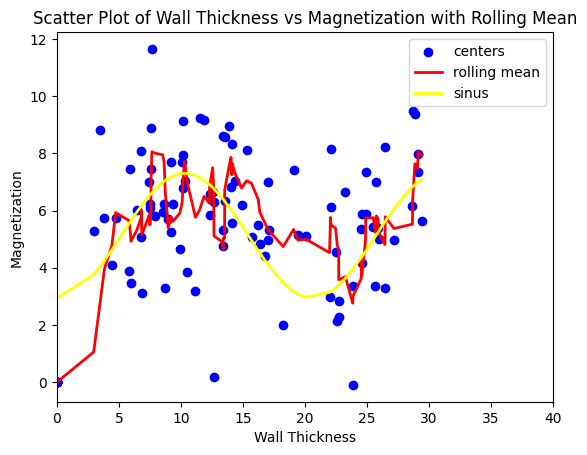

'centers used: 122'

array([ 5.21041341,  0.31872876, -1.6064569 , 10.33360209])

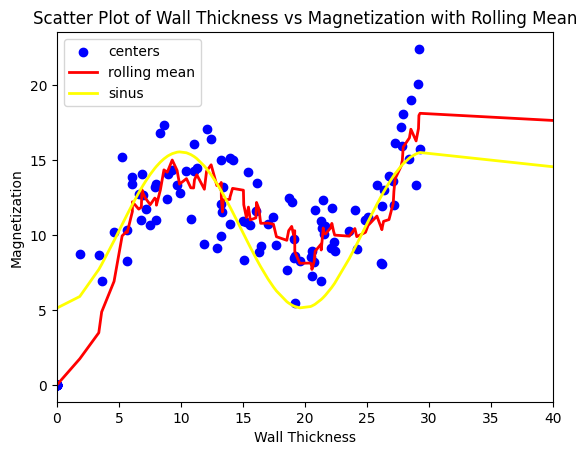

'centers used: 120'

array([ -4.63415298,   0.28674319,  -1.07356342, -13.89801397])

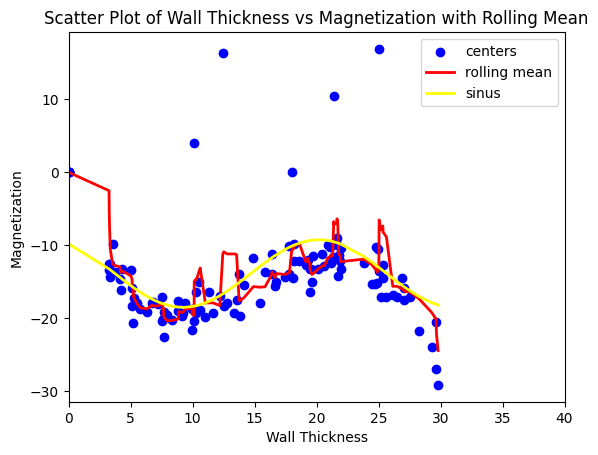

'centers used: 132'

array([-2.80866339,  0.31977082, -1.70069232, -6.67104512])

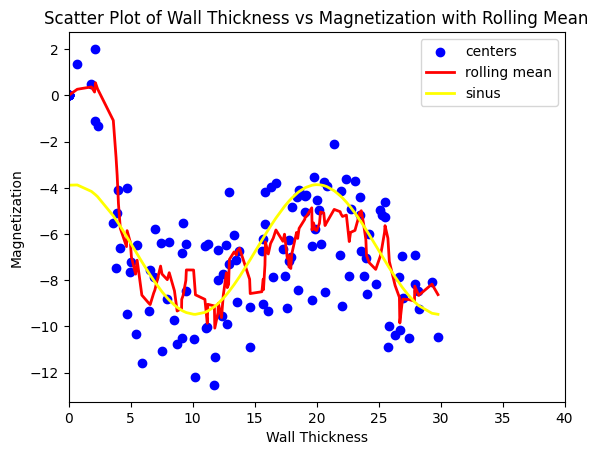

'centers used: 124'

array([ 7.06110063,  0.29531718, -1.39833968, 18.51338856])

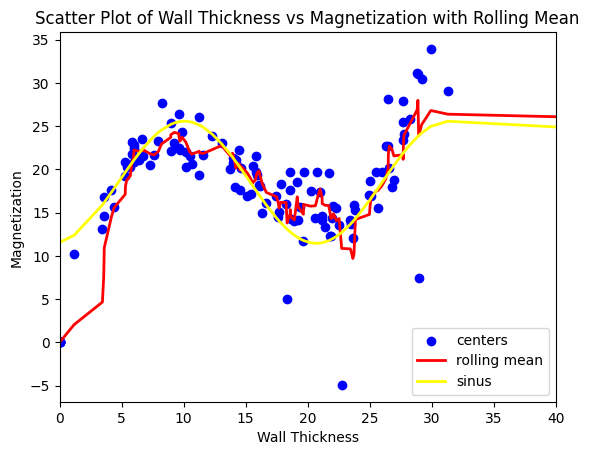

In [158]:
from scipy.optimize import curve_fit

dfs = {}

# filter only by instrument, configuration currently not distinguished
for name in files["instrument"].unique():
    temp_df = files[files["instrument"] == name]

    temp_df = temp_df.apply(prepare_data, axis=1, args=[False])
    
    array_wall_thickness = np.concatenate(temp_df["wall_thickness"].values)
    array_magnetization = np.concatenate(temp_df["magnetization"].values)
    array_velocity = np.concatenate(temp_df["velocity"].values)
    array_centers = np.concatenate(temp_df["centers"].values)
    
    d = pd.DataFrame(array_centers)
    d.columns = ["wall_thickness", "magnetization", "velocity"]
    
    display(f"centers used: {d["magnetization"].count()}")
    #d.plot(kind="scatter", x="wall_thickness", y="magnetization", title=f"center plot {name}", xlim=(0,40), ylim=(-10, 10))

    d.sort_values(by="wall_thickness", inplace=True)
    
    #remove outlier
    outliers = zscore_create_outliers_mask(d["magnetization"], 3)
    d = d[outliers]
    
    
    [params, covariance] = curve_fit(sin_func, d["wall_thickness"], d["magnetization"], [5, 0.3, -1.5, -10])
    #fix b
    #params[0] = 5
    #params[1] = 0.3
    #params[2] = -1.5
    
    display(params)
    
    plt.figure()
    plt.xlim(0, 40)
    #plt.ylim(-10, 10)
    plt.scatter(d['wall_thickness'], d['magnetization'], label='centers', color='blue')
    plt.plot(d['wall_thickness'], d["magnetization"].rolling(5).mean(), label='rolling mean', color='red', linewidth=2)
    plt.plot(d['wall_thickness'], sin_func(d["wall_thickness"], *params), label='sinus', color='yellow', linewidth=2)


# Beschriftungen und Legende
    plt.title('Scatter Plot of Wall Thickness vs Magnetization with Rolling Mean')
    plt.xlabel('Wall Thickness')
    plt.ylabel('Magnetization')
    plt.legend()
    
    plt.show()
    
    new_df = pd.DataFrame({"wall_thickness": array_wall_thickness, "magnetization": array_magnetization, "velocity": array_velocity})
    dfs[name] = new_df
    
    #fig = plt.figure()
    #ax = fig.add_subplot(111, projection='3d')

    #d = d[d["velocity"] < 2]
    
    x = d['wall_thickness']
    y = d['magnetization']
    z = np.zeros(len(d)) 
    c = np.abs(d['velocity'])
    
    #ax.scatter(x, y, z, c=c, cmap='viridis')
    
    #ax.set_xlabel('Wall Thickness')
    #ax.set_ylabel('Magnetization (corrected)')
    #ax.set_zlabel('Velocity')
    #ax.set_title(f'Wall Thickness vs. Corrected Magnetization with Velocity as Third Dimension {name}')
    
    #display(temp_df.head())
    #temp
    #break

    # Erstellung des Scatter Plots



'Unicorn'

'Pufferfish'

'Dolphin'

'Dog'

'Elephant'

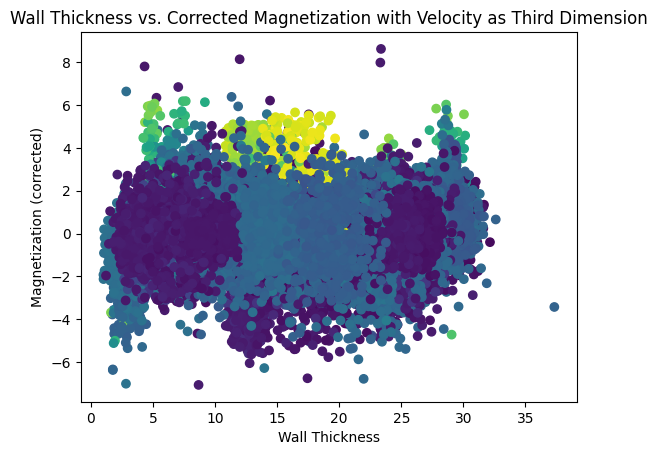

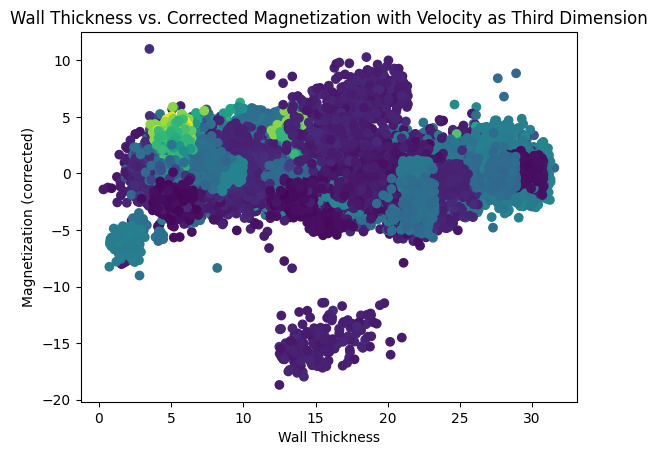

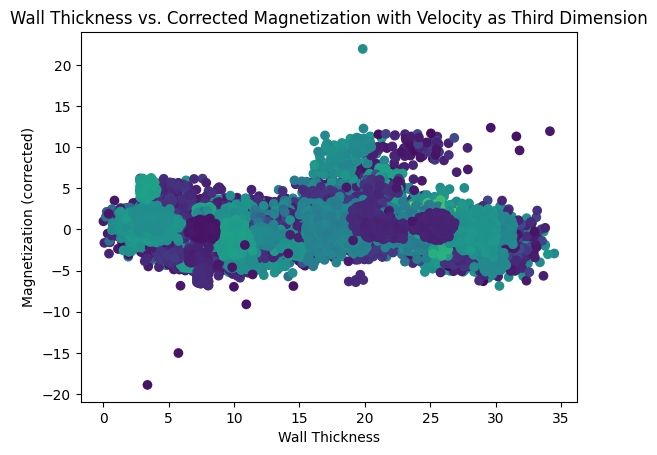

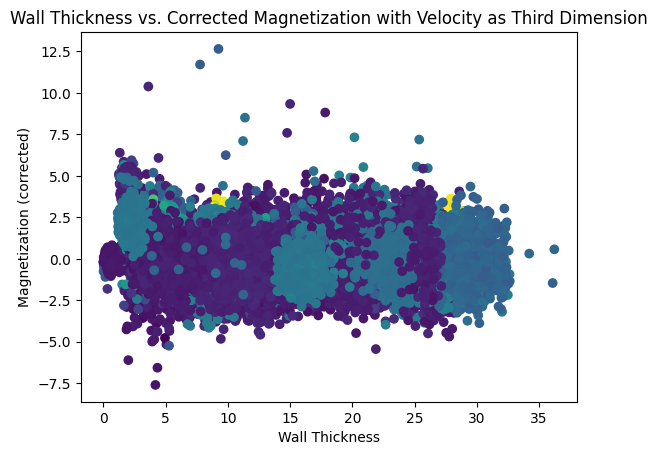

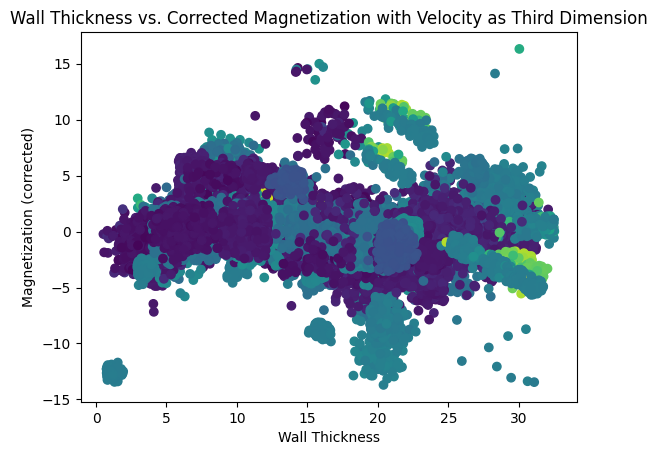

In [95]:
for instrument, df in dfs.items():
    display(instrument)
    #display(df.plot(kind="scatter", x="wall_thickness", y="magnetization", xlim=(0, 40), ylim=(0, 40)))
    
    fig = plt.figure()
    ax = fig.add_subplot()
    
    x = df['wall_thickness']
    y = df['magnetization']
    z = np.zeros(len(df)) 
    c = np.abs(df['velocity'])
    
    ax.scatter(x, y, c=c, cmap='viridis')
    
    ax.set_xlabel('Wall Thickness')
    ax.set_ylabel('Magnetization (corrected)')
    ax.set_title('Wall Thickness vs. Corrected Magnetization with Velocity as Third Dimension')
    
    

hier ist wahrscheinlich irgendwo der effekt mit den "langgezogenen punktwolken" aufgrund der abnutzung der kontakte drin

In [7]:
files.head()

,_id,instrument,configuration,magnetization,wall_thickness
0,006b0b34-324b-496a-8ed7-a40f7d689ee9,Unicorn,Europe,"[0.27603825323679154, 97.86067498679706, 2.207...","[23.99222341036084, 24.10463223116243, 22.7322..."
1,0108e474-f1f4-4274-bf9f-e51d4963c091,Pufferfish,Europe,"[9.436639690926366, 7.864456069974779, 11.0914...","[21.653860163116526, 21.2720484396535, 26.1405..."
2,03da0eaa-98db-40d3-87bf-73ade130ac7c,Pufferfish,Europe,"[13.013569081675818, 11.457331570306037, 12.72...","[13.237698486111132, 4.135358086358272, 13.752..."
3,041849e0-d9ce-4ce1-b325-dcc5df055b80,Dolphin,Europe,"[-17.5514024471966, -16.797828223966338, -17.3...","[6.99012365895839, 6.6095069463976595, 7.07231..."
4,046eb9c7-f409-4125-a9c7-c237094ab837,Dog,Europe,"[-5.753318330394104, -4.892938582370071, -6.44...","[25.553738081262658, 13.500313367948351, 18.97..."
